# Explore word co-occurence counts

This notebook explores the raw word co-occurence counts from a corpus. Background material for this notebook can be found in https://web.stanford.edu/~jurafsky/slp3/15.pdf. 

The notebook loads a pre-computed word co-occurence matrix and vocabulary and some some initial exploration e.g. look at word count statistics. 

Note that the word co-occurence matrix, `counts` is a scipy sparse matrix which which works a little differently than numpy matrices -- for further documentaiton see https://docs.scipy.org/doc/scipy/reference/sparse.html.

## data

The github repo comes with a small data set (from a random sample of 1000 court cases). You can download larger data files from https://drive.google.com/open?id=0B40b05f-8LWtVGsybWw4OTVyV00 then place them in the data/ folder.

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt


# import local code files
import sys, os
sys.path.append(os.getcwd() + '/code/')

from save import load_vocabulary, load_matrix
from explore_counts_fun import top_counts_bar_plot, co_counts_intersection

%load_ext autoreload
%autoreload 2
%matplotlib inline

**load word co-occurence matrix and vocabulary**

- `co_counts` is scipy sparse matrix (see https://docs.scipy.org/doc/scipy/reference/sparse.html).
- `w2i` is a dictionary mappting words to a unique index matching the rows of `counts`
- `i2w` is a list mapping indices to words
- `word_counts` is a dict displaying the number of times each word each word appears

In [2]:
w2i, i2w = load_vocabulary('data/vocab_small_ex.txt')
co_counts = load_matrix('data/co_counts_small_ex')
word_counts = np.load('data/word_counts_small_ex.npy')

# uncomment this code if you have the larger data file
# w2i, i2w = load_vocabulary('data_no_github/vocab_10000.txt')
# co_counts = load_matrix('data_no_github/co_counts_10000')
# word_counts = np.load('data_no_github/word_counts_10000.npy')

In [3]:
co_counts

<39424x39424 sparse matrix of type '<class 'numpy.float64'>'
	with 11250370 stored elements in Compressed Sparse Row format>

In [4]:
print(w2i['lawyer'])
print(i2w[15788])

35276
noniolta


In [5]:
print(co_counts[w2i['lawyers'], w2i['criminal']])

28.0


In [6]:
word_counts[w2i['lawyer']]

129

# explore word occurence counts

In [7]:
N = 20
heapq.nlargest(N, zip(word_counts, i2w)) # this piece of code finds the largest values of total_word_counts

[(151580, 'the'),
 (79328, 'of'),
 (50251, 'to'),
 (38481, 'and'),
 (37888, 'in'),
 (30474, 'a'),
 (29977, 'that'),
 (18245, 'is'),
 (16523, 'for'),
 (15602, 'by'),
 (14440, 'it'),
 (13808, 'as'),
 (13629, 'not'),
 (13462, 'court'),
 (13360, 'be'),
 (13218, 'was'),
 (12384, 'or'),
 (10517, 'on'),
 (10355, 'this'),
 (9143, 'v')]

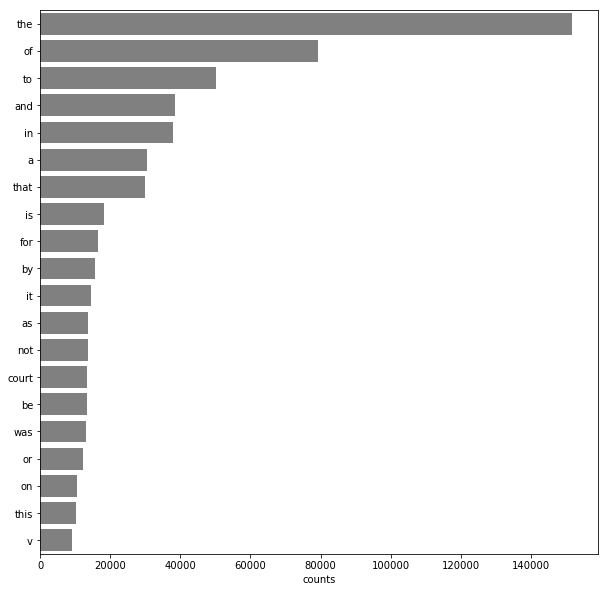

In [8]:
top_counts_bar_plot(word_counts,
                    i2w,
                    N=20,
                    title='',
                    figsize=[10, 10])

# co-occurence statistics for a single word

In [9]:
word = 'violent'

# vector of co-occurence counts for word
# the .toarray().reshape(-1) converts the row vector to a numpy array
word_co_counts = co_counts[w2i[word], :].toarray().reshape(-1) 

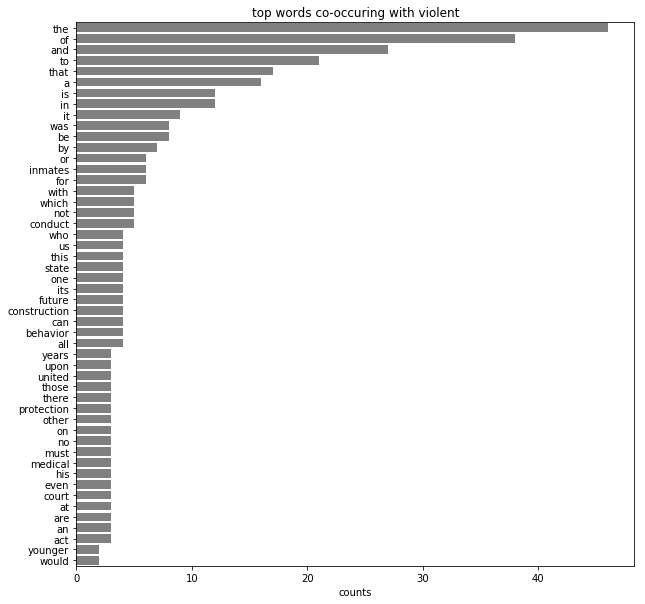

In [10]:
top_counts_bar_plot(word_co_counts,
                    i2w,
                    N=50,
                    title='top words co-occuring with %s' % word,
                    figsize=[10, 10])

In [11]:
# plt.figure(figsize=[10, 10])
# plt.hist(word_coo_counts, bins=1000)#np.arange(max(word_coo_counts)));
# plt.xlim([0, max(word_coo_counts)])
# plt.xlabel('counts')
# plt.title('histogram of co-occurence couts for all words with %s'% word)


# print 'mean: %f' % np.mean(word_coo_counts)
# print 'var: %f' % np.var(word_coo_counts)

# word similarity

Given the word co-occurence statistics, we can compute similarities between two words using a number of measures (e.g. see section 15.3 https://web.stanford.edu/~jurafsky/slp3/15.pdf). 


The code below is also in word_similarity.py.

In [12]:
def similarity(word1, word2, sim='angle'):
    """
    Computes the similarity between two words
    
    Parameters
    ----------
    word1, word2: words to compare
    sim: which similarity measure to use (angle, cosine, jaccard, dice)
    
    Returns
    -------
    similarity measure between two words
    """
    
    v1 = vec(word1)
    v2 = vec(word2)

    if sim == 'angle':
        return angle_between(v1, v2)
    elif sim == 'cosine':
        return cosine_sim(v1, v2)
    elif sim == 'jaccard':
        return jaccard_sim(v1, v2)
    elif sim == 'dice':
        return dice_sim(v1, v2)
    else:
        raise ValueError('sim must be one of: angle, cosine, jaccard, dice')

def vec(word):
    """
    Returns the vector for word as an array
    """
    return co_counts[w2i[word], :].toarray().reshape(-1)

** here are a few common similarity functions**

In [13]:
def cosine_sim(v, w):
    return np.dot(v, w) / np.sqrt(np.dot(v, v) * np.dot(w, w))

def angle_between(v, w):
    cos_angle = cosine_sim(v, w)
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    return np.degrees(angle)

def jaccard_sim(v, w):
    return np.minimum(v, w).sum()/np.maximum(v, w).sum()

def dice_sim(v, w):
     return 2.0 * np.minimum(v, w).sum() /(v + w).sum()

In [17]:
word1 = 'lawyer'
word2 = 'criminal'

print('similarity between %s and %s' % (word1, word2))
print()
print('angle: %f' % similarity(word1, word2, sim='angle'))
print('cosine: %f' % similarity(word1, word2, sim='cosine'))
print('jaccard: %f' % similarity(word1, word2, sim='jaccard'))
print('dice: %f' % similarity(word1, word2, sim='dice'))

similarity between lawyer and criminal

angle: 15.136553
cosine: 0.965306
jaccard: 0.122026
dice: 0.217510


In [16]:
word1 = 'lawyer'
word2 = 'lawyers'
words_both, c1, c2 = co_counts_intersection(co_counts, word1, word2, w2i, i2w, threshold=20)
words_both

['the',
 'for',
 'it',
 'any',
 'trial',
 'by',
 'be',
 'that',
 'is',
 'as',
 'and',
 'of',
 'not',
 'in',
 'an',
 'or',
 'to',
 'at',
 'a']